<a href="https://colab.research.google.com/github/bpratham2001/GSoC/blob/main/ML4SCI/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photon/Electron Classification with ResNet15

Description: 32x32 matrices with two channels: hit energy and time for two types of
particles, electrons and photons, hitting the detector.

Please use a Resnet-15 (you are free to play around with the architecture) like model,
to achieve the highest possible classification score on this image dataset.
Please provide a Jupyter notebook that shows your solution along with the model weights.
Preferably only use PyTorch or Keras in your solutions.

Please train your model on 80% of the data and evaluate on the remaining 20%.
Please make sure not to overfit on the test dataset - it will be checked with an independent sample.

In [1]:
# @title !wget datasets

#!wget https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
#!wget https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

In [2]:
# @title imports and installs

#!pip install h5py
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import datetime
import seaborn as sns
import pandas as pd

In [3]:
# @title Loading data as tensors onto device

photons = "/kaggle/working/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electrons = "/kaggle/working/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

def get_hdf5(path):
  with h5py.File(path, 'r') as file:
    X_data = file['X'][:]
    y_data = file['y'][:]
  return X_data, y_data

Xphoton, yphoton = get_hdf5(photons)
Xphoton = np.array(Xphoton)
yphoton = np.array(yphoton)

Xelectron, yelectron = get_hdf5(electrons)
Xelectron = np.array(Xelectron)
yelectron = np.array(yelectron)

photon_split = int(0.8*len(yphoton))
electron_split = int(0.8*len(yelectron))

Xtrain = np.concatenate((Xphoton[:photon_split],Xelectron[:electron_split]))
ytrain = np.concatenate((yphoton[:photon_split],yelectron[:electron_split]))
Xtest = np.concatenate((Xphoton[photon_split:],Xelectron[electron_split:]))
ytest = np.concatenate((yphoton[photon_split:],yelectron[electron_split:]))

#####
torch.cuda.empty_cache()
batch_size = 400
del Xphoton, yphoton, Xelectron, yelectron

X_tensor = torch.tensor(Xtrain, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(ytrain,dtype=torch.float32) #change to int64 when using non-binary loss
#y_tensor = nn.functional.one_hot(y_tensor, num_classes=2).to(torch.float32)

X_tensor_test = torch.tensor(Xtest, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor_test = torch.tensor(ytest,dtype=torch.float32) #change to int64 when using non-binary loss
#y_tensor_test = nn.functional.one_hot(y_tensor_test, num_classes=2).to(torch.float32)

del Xtrain, ytrain, Xtest, ytest

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
train_set = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

X_tensor_test = X_tensor_test.to(device)
y_tensor_test = y_tensor_test.to(device)
test_set = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


# Architecture

**ResNet15 Architecture source:** https://onlinelibrary.wiley.com/doi/epdf/10.1155/2020/6972826

As there have been no explicit instructions as to what constitutes "playing around with the architecture", every effort has been made to keep it as true to the original as possible.

**input**  2 channels

**conv1**  2->32

**maxPool**

**resBlock1** 32 -> 64

**resBlock2** 64 ->128

**resBlock3** 128->256

**resBlock4** 256->512

**fc1**  512->2

**softmax**

**output**  2 probabilities

Initially, the model was implemented with a fully connected layer with 1 output channel, and no softmax activation. The criterion was binary cross entropy with logits loss, which has integrated sigmoid activation for improved stability. However, the model struggled exceed 1% accuracy due to the data being treated as a binary classification problem. The understanding is that the features being learnt by the model were insufficient for an either/or problem, and hence the problem was restructured as a 2-class classification by way of 1-hot encoding the labels. This enabled the model to output probabilites for the data being labelled as containing both photon and electron, instead of the binary problem of whether or not is a photon.

In [4]:
# @title ResNet15 Implementation

class ResBlock(nn.Module):
  # This is the residual block, there are 4 residual blocks in ResNet15
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResBlock, self).__init__()
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=stride, padding=0, bias=False)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(in_channels)
    
    self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
    nn.init.kaiming_normal_(self.conv2.weight)
    self.bn2 = nn.BatchNorm2d(in_channels)
    
    self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
    nn.init.kaiming_normal_(self.conv3.weight)
    self.bn3 = nn.BatchNorm2d(out_channels)
    
    self.shortcut = nn.Sequential()
      
    if stride != 1 or in_channels != out_channels:
      shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
      nn.init.kaiming_normal_(shortcut_conv.weight)
      self.shortcut.append(shortcut_conv)
      self.shortcut.append(nn.BatchNorm2d(out_channels))

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    out += self.shortcut(x)
    out = self.relu(out)
    return out

class ResNet15(nn.Module):
  def __init__(self, num_classes=2):
    super(ResNet15, self).__init__()
    
    self.conv1 = nn.Conv2d(2, 32, kernel_size=1, stride=1, padding=0, bias=False)
    nn.init.kaiming_normal_(self.conv1.weight)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU(inplace=True)
    
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    
    self.res1 = ResBlock(32, 64)
    self.res2 = ResBlock(64, 128)
    self.res3 = ResBlock(128, 256)
    self.res4 = ResBlock(256, 512)
    
    self.fc1 = nn.Linear(512 * 32 * 32, 1)
    nn.init.kaiming_normal_(self.fc1.weight)
      
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.res1(out)
    out = self.res2(out)
    out = self.res3(out)
    out = self.res4(out)
    out = torch.flatten(out, 1)
    out = self.fc1(out)
    #out = self.sigmoid(out)
    return out

#def kaiming_normal(layer):
#  return nn.init.kaiming_normal_(layer, mode='fan_out', nonlinearity='relu')

def get_accuracy(outputs, labels, bcewithlogitsloss=False):
  correct = 0
  if bcewithlogitsloss:
    sig = nn.Sigmoid()
    outputs = sig(outputs)
  for i in range(len(outputs)):
    if (outputs[i] > 0.5 and labels.unsqueeze(1)[i] == 1.0) or (outputs[i] <= 0.5 and labels.unsqueeze(1)[i] == 0.0):
      correct += 1
  return (correct/len(outputs))*100

In [5]:
# @title Loading the Model

path = '' # 'resnet15_photo_electro_classifier.pth'
model = ResNet15()
    
if torch.cuda.device_count() > 1:
  print("Using ", torch.cuda.device_count(), "GPUs")
  model = nn.DataParallel(model)
else:
  print(X_tensor.device)
if path != '':
  model.load_state_dict(torch.load(f=path))
    
model = model.to(device)

criterion = nn.BCEWithLogitsLoss().to(device)
#criterion = nn.BCELoss().to(device)
#optimiseur = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimiseur = torch.optim.Adam(model.parameters(),lr=0.01)

cuda:0


In [6]:
# @title Training

print("Training started at", datetime.datetime.now())
plotloss = []
epochs = 25
flag = False

model.train()
for epoch in range(epochs):
  running_loss = 0.0
  
  if epoch == 12:
    optimiseur = torch.optim.Adam(model.parameters(),lr=0.001)
  if epoch == 20:
    optimiseur = torch.optim.Adam(model.parameters(),lr=0.0001)

  if epoch % 10 == 0:
    torch.save(obj=model.state_dict(), f="resnet15_checkpoint_"+str(epoch)+".pth")
  
  acc= []
  for i, (inputs, labels) in enumerate(train_loader):
    outputs = model(inputs)
    if flag:
      print(outputs) #torch.flatten(torch.rot90(outputs)))
      print(labels) #torch.flatten(labels))
      flag = False
    loss = criterion(outputs, labels.unsqueeze(1))
    optimiseur.zero_grad()
    loss.backward()
    optimiseur.step()
    running_loss += loss.item()
    acc.append(get_accuracy(outputs, labels, True))
  print(f"E [{epoch + 1}/{epochs}], L: {running_loss:.4f}, avg: {(sum(acc)/len(acc)):.4f}")
  print(f"T [{datetime.datetime.now()}]")
  plotloss.append(running_loss)

Training started at 2025-03-22 18:41:19.200323
E [1/25], L: 2238.2721, avg: 57.5866
T [2025-03-22 18:48:44.616084]
E [2/25], L: 638.5329, avg: 64.3225
T [2025-03-22 18:56:08.707782]
E [3/25], L: 608.9127, avg: 67.7992
T [2025-03-22 19:03:32.865268]
E [4/25], L: 595.2482, avg: 69.0349
T [2025-03-22 19:10:56.945909]
E [5/25], L: 583.0600, avg: 70.0740
T [2025-03-22 19:18:20.921374]
E [6/25], L: 573.5072, avg: 70.8532
T [2025-03-22 19:25:44.646217]
E [7/25], L: 568.9590, avg: 71.2106
T [2025-03-22 19:33:08.238607]
E [8/25], L: 566.4853, avg: 71.3918
T [2025-03-22 19:40:31.849707]
E [9/25], L: 564.0546, avg: 71.6044
T [2025-03-22 19:47:55.341918]
E [10/25], L: 579.3359, avg: 70.6298
T [2025-03-22 19:55:19.167160]
E [11/25], L: 568.2635, avg: 71.1486
T [2025-03-22 20:02:42.664355]
E [12/25], L: 563.8734, avg: 71.5387
T [2025-03-22 20:10:06.189495]
E [13/25], L: 549.5700, avg: 72.6300
T [2025-03-22 20:17:29.638754]
E [14/25], L: 546.1289, avg: 72.7957
T [2025-03-22 20:24:52.988409]
E [15/25]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

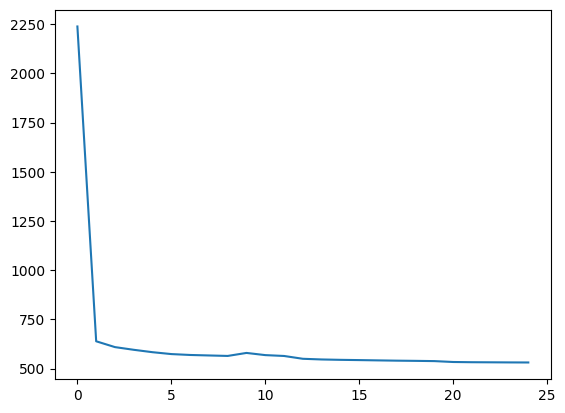

In [7]:
#sns.set(style='darkgrid')
sns.lineplot(x=np.array(list(range(epochs))), y=np.array(plotloss))
#plt.show()

In [10]:
# @title Testing

model.eval()
val_loss = 0.0
#correct = 0
#total = 0
acc = []
with torch.no_grad():
  for inputs, labels in test_loader:
    outputs = model(inputs)
    loss = criterion(outputs, labels.unsqueeze(1))
    val_loss += loss.item()
    #total += labels.size(0)
    #outputs = torch.round(outputs)
    #correct += (outputs == labels).sum().item()
    acc.append(get_accuracy(outputs, labels, True))
      
print(f'L: {val_loss:.4f}, avg: {(sum(acc)/len(acc)):.2f}%')

L: 135.7679, avg: 73.08%


In [12]:
# @title Saving
torch.save(obj=model.state_dict(), f="resnet15_photo_electro_classifier.pth")